# The relationship between spatial coupling and incidence correlation in a 2-patch model
Ref: Keeling & Rohani, _Estimating spatial coupling in epidemiological systems: a mechanistic approach_, Ecol. Letters (2002) 5:20-29


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import fsolve

from laser.core.propertyset import PropertySet

import laser.core.distributions as dists
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator
from laser_generic.models import SIR
from laser_generic.models.model import Model
from laser_generic.newutils import ValuesMap
from laser_generic.newutils import grid

import laser.core
import laser_generic

print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser_generic.__version__=}")

np.__version__='2.3.4'
laser.core.__version__='0.6.0'
laser_generic.__version__='0.0.0'


In [6]:
class Importation:
    def __init__(self, model, infdurdist, infdurmin: int =1, period: int = 180, count: int = 3):
        self.model = model
        self.infdurdist = infdurdist
        self.infdurmin = infdurmin
        self.period = period
        self.count = count

        self.model.nodes.add_vector_property("imports", model.params.nticks + 1, dtype=np.uint32, default=0)

        return
    
    def step(self, tick: int) -> None:
        if tick > 0 and tick % self.period == 0:
            i_susceptible = np.nonzero(self.model.people.state == SIR.State.SUSCEPTIBLE.value)[0]
            if len(i_susceptible) > 0:
                count = min(self.count, len(i_susceptible))
                i_infect = np.random.choice(i_susceptible, size=count, replace=False)
                self.model.people.state[i_infect] = SIR.State.INFECTIOUS.value
                samples = dists.sample_floats(self.infdurdist, np.zeros(count, np.float32))
                samples = np.round(samples)
                samples = np.maximum(samples, self.infdurmin).astype(self.model.people.itimer.dtype)
                self.model.people.itimer[i_infect] = samples
                inf_by_node = np.bincount(self.model.people.nodeid[i_infect], minlength=len(self.model.nodes)).astype(self.model.nodes.S.dtype)
                self.model.nodes.S[tick + 1] -= inf_by_node
                self.model.nodes.I[tick + 1] += inf_by_node
                self.model.nodes.imports[tick] = inf_by_node
            # else:
            #     print(f"No susceptibles to infect at tick {tick}")

        return

In [8]:
import os

# Set parameters to match those of Keeling & Rohani, 2002.  They have a constant importation rate of 5.5e-5*sqrt(N) per day,
# which for this sim would be something like 40 per year.  I'm importing 6 per year, but I don't think that should be the big deal.
# more important is setting the birth, R0, and infectious period to their numbers and then seeing the
# connectivity-correlation relationship.
nticks = 36500
pop = 1e6
scenario = grid(M=1, N=2, node_size_km=10, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
initial_infected = 1
scenario["S"] = np.array([pop - initial_infected, pop])
scenario["I"] = np.array([initial_infected, 0])
scenario["R"] = np.array([0, 0])
parameters = PropertySet(
    {
        "seed": 4,
        "nticks": nticks,
        "verbose": True,
        "beta": 17 / 13,
        "inf_mean": 13,
        "cbr": 20.277294,
        "importation_period": 180,
        "importation_count": 3,
    }
)
birthrate_map = ValuesMap.from_scalar(parameters.cbr, nnodes=len(scenario), nsteps=parameters.nticks)

infdurdist = dists.exponential(scale=parameters.inf_mean)
rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) #to get stable population, small correction factor for the annual age-dist/KM estimators.
stable_age_dist = np.array(1000*np.exp(-rate_const*np.arange(89)))
pyramid = AliasedDistribution(stable_age_dist)
survival = KaplanMeierEstimator(stable_age_dist.cumsum())


nsims = 10
i = 0
outputs = np.zeros((nsims, parameters.nticks+1, scenario.shape[0]))
connections = np.logspace(-4, -1, nsims)
for connection in connections:
    model = Model(scenario, parameters, birthrates=birthrate_map.values)
    model.components = [
        SIR.Susceptible(model),
        SIR.Recovered(model),
        SIR.Infectious(model, infdurdist),
        Importation(model, infdurdist),
        SIR.Transmission(model, infdurdist),
        SIR.VitalDynamics(model, birthrates=birthrate_map.values, pyramid=pyramid, survival=survival)
    ]

    # Start them slightly asynchronously - different initial susceptibilities, infection only in 1 patch
    # Want to see how connectivity drives correlation over time.
    model.network = np.array([[0, connection], [connection, 0]])

    model.run()
    outputs[i, :, :] = model.nodes.I
    #np.save(f"{output_folder}/twopatchSIRoutputs_{i}.npy", outputs[i, :, :])
    i += 1

2000000 agents in f2 nodes: 100%|██████████| 36500/36500 [01:12<00:00, 500.51it/s]


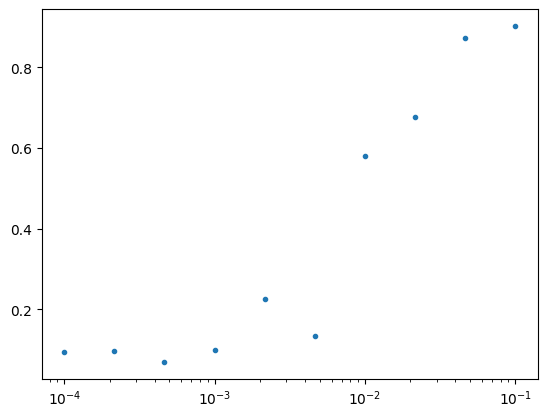

In [11]:
correlations = []
last_50_years = 50 * 365  # 50 years in days

for sim in range(outputs.shape[0]):
    patch1_data = outputs[sim, -last_50_years:, 0]
    patch2_data = outputs[sim, -last_50_years:, 1]
    correlation = np.corrcoef(patch1_data, patch2_data)[0, 1]
    correlations.append(correlation)

correlations = np.array(correlations)
plt.plot(connections, correlations, '.')
plt.xscale('log')

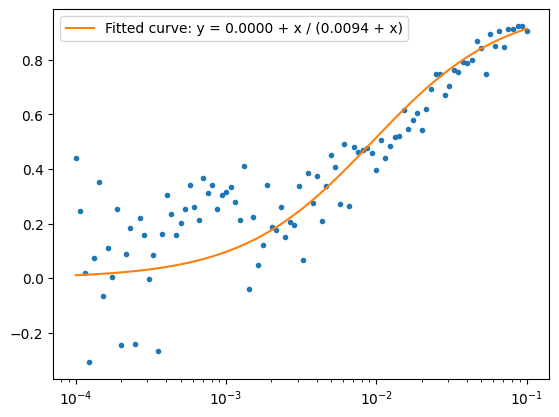

Bad pipe message: %s [b'\xba\xca\x81FN\x15\xa2T\xa8\x0b\x7f\xdat\xf6dCo\xa7\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00']
Bad pipe message: %s [b',d8\xbb\xcf\x0c\xbeK\x84q\xa1\x9f\xe9is\x06\xb7\x8a\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x

In [54]:
from scipy.optimize import curve_fit

x = np.logspace(-4, -1, nsims)


# Define the function to fit
def func(x, psi, beta):
    return beta + x / (psi + x)


# Fit the curve
popt, pcov = curve_fit(func, x, correlations, p0=[0.01, 0], bounds=([1e-6, -0.00002], [1, 0.00002]))
psi_opt = popt[0]
beta_opt = popt[1]
plt.plot(x, correlations, ".")
plt.xscale("log")
# Plot the fitted curve
plt.plot(x, func(x, psi_opt, beta_opt), label=f"Fitted curve: y = {beta_opt:.4f} + x / ({psi_opt:.4f} + x)")
plt.legend()